# 2 - Workflow management with atomate

In this lesson we cover a few more advanced features of the atomate software package.  More specifically we'll go over an example that includes parents and children, talk more about where you can find preset workflows, and cover a basic example of analyzing workflow-generated materials data.

In [4]:
from mp_workshop.atomate import wf_to_graph, use_fake_vasp_workshop
from tqdm import tqdm_notebook


## Why use atomate?

Just to motivate this lesson a bit more, I'd like to share an example that illustrates the value of atomate.  Let's say you wanted to calculate the bandstructure of every polymorph of SiO$_2$.  Normally, you'd need to get all of the cifs from MP or the ICSD, construct the POSCARs by hand, or use some of your own infrastructure to convert them, run the calculations and manage the directory structure, and aggregate the results in a way that allowed you to analyze them together.  In atomate, this is achieved in a simple, five line snippet:

In [5]:
from atomate.vasp.workflows.presets.core import get_wf
from fireworks import LaunchPad

lpad = LaunchPad.auto_load()
lpad.reset("", require_password=False)

from pymatgen import MPRester
mpr = MPRester('')

structures = mpr.get_structures("SiO2")
for structure in tqdm_notebook(structures):
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2019-07-24 22:48:56,049 INFO Performing db tune-up
2019-07-24 22:48:56,093 INFO LaunchPad was RESET.


2019-07-24 22:48:59,133 INFO Added a workflow. id_map: {-4: 1, -3: 2, -2: 3, -1: 4}
2019-07-24 22:48:59,161 INFO Added a workflow. id_map: {-8: 5, -7: 6, -6: 7, -5: 8}
2019-07-24 22:48:59,178 INFO Added a workflow. id_map: {-12: 9, -11: 10, -10: 11, -9: 12}
2019-07-24 22:48:59,194 INFO Added a workflow. id_map: {-16: 13, -15: 14, -14: 15, -13: 16}
2019-07-24 22:48:59,222 INFO Added a workflow. id_map: {-20: 17, -19: 18, -18: 19, -17: 20}
2019-07-24 22:48:59,244 INFO Added a workflow. id_map: {-24: 21, -23: 22, -22: 23, -21: 24}
2019-07-24 22:48:59,255 INFO Added a workflow. id_map: {-28: 25, -27: 26, -26: 27, -25: 28}
2019-07-24 22:48:59,292 INFO Added a workflow. id_map: {-32: 29, -31: 30, -30: 31, -29: 32}
2019-07-24 22:48:59,319 INFO Added a workflow. id_map: {-36: 33, -35: 34, -34: 35, -33: 36}
2019-07-24 22:48:59,355 INFO Added a workflow. id_map: {-40: 37, -39: 38, -38: 39, -37: 40}
2019-07-24 22:48:59,378 INFO Added a workflow. id_map: {-44: 41, -43: 42, -42: 43, -41: 44}
2019-0

2019-07-24 22:49:01,748 INFO Added a workflow. id_map: {-344: 341, -343: 342, -342: 343, -341: 344}
2019-07-24 22:49:01,779 INFO Added a workflow. id_map: {-348: 345, -347: 346, -346: 347, -345: 348}
2019-07-24 22:49:01,796 INFO Added a workflow. id_map: {-352: 349, -351: 350, -350: 351, -349: 352}
2019-07-24 22:49:01,839 INFO Added a workflow. id_map: {-356: 353, -355: 354, -354: 355, -353: 356}
2019-07-24 22:49:01,878 INFO Added a workflow. id_map: {-360: 357, -359: 358, -358: 359, -357: 360}
2019-07-24 22:49:01,933 INFO Added a workflow. id_map: {-364: 361, -363: 362, -362: 363, -361: 364}
2019-07-24 22:49:01,967 INFO Added a workflow. id_map: {-368: 365, -367: 366, -366: 367, -365: 368}
2019-07-24 22:49:01,987 INFO Added a workflow. id_map: {-372: 369, -371: 370, -370: 371, -369: 372}
2019-07-24 22:49:02,051 INFO Added a workflow. id_map: {-376: 373, -375: 374, -374: 375, -373: 376}
2019-07-24 22:49:02,089 INFO Added a workflow. id_map: {-380: 377, -379: 378, -378: 379, -377: 380}


2019-07-24 22:49:04,431 INFO Added a workflow. id_map: {-672: 669, -671: 670, -670: 671, -669: 672}
2019-07-24 22:49:04,442 INFO Added a workflow. id_map: {-676: 673, -675: 674, -674: 675, -673: 676}
2019-07-24 22:49:04,453 INFO Added a workflow. id_map: {-680: 677, -679: 678, -678: 679, -677: 680}
2019-07-24 22:49:04,472 INFO Added a workflow. id_map: {-684: 681, -683: 682, -682: 683, -681: 684}
2019-07-24 22:49:04,487 INFO Added a workflow. id_map: {-688: 685, -687: 686, -686: 687, -685: 688}
2019-07-24 22:49:04,526 INFO Added a workflow. id_map: {-692: 689, -691: 690, -690: 691, -689: 692}
2019-07-24 22:49:04,578 INFO Added a workflow. id_map: {-696: 693, -695: 694, -694: 695, -693: 696}
2019-07-24 22:49:04,596 INFO Added a workflow. id_map: {-700: 697, -699: 698, -698: 699, -697: 700}
2019-07-24 22:49:04,625 INFO Added a workflow. id_map: {-704: 701, -703: 702, -702: 703, -701: 704}
2019-07-24 22:49:04,663 INFO Added a workflow. id_map: {-708: 705, -707: 706, -706: 707, -705: 708}


2019-07-24 22:49:06,390 INFO Added a workflow. id_map: {-1000: 997, -999: 998, -998: 999, -997: 1000}
2019-07-24 22:49:06,401 INFO Added a workflow. id_map: {-1004: 1001, -1003: 1002, -1002: 1003, -1001: 1004}
2019-07-24 22:49:06,413 INFO Added a workflow. id_map: {-1008: 1005, -1007: 1006, -1006: 1007, -1005: 1008}
2019-07-24 22:49:06,426 INFO Added a workflow. id_map: {-1012: 1009, -1011: 1010, -1010: 1011, -1009: 1012}
2019-07-24 22:49:06,439 INFO Added a workflow. id_map: {-1016: 1013, -1015: 1014, -1014: 1015, -1013: 1016}
2019-07-24 22:49:06,490 INFO Added a workflow. id_map: {-1020: 1017, -1019: 1018, -1018: 1019, -1017: 1020}
2019-07-24 22:49:06,553 INFO Added a workflow. id_map: {-1024: 1021, -1023: 1022, -1022: 1023, -1021: 1024}
2019-07-24 22:49:06,615 INFO Added a workflow. id_map: {-1028: 1025, -1027: 1026, -1026: 1027, -1025: 1028}
2019-07-24 22:49:06,643 INFO Added a workflow. id_map: {-1032: 1029, -1031: 1030, -1030: 1031, -1029: 1032}
2019-07-24 22:49:06,657 INFO Added

This snippet attests to the so-called "high-throughput" approach, which has value both because it enables you to aggregate a lot of data quickly in a way that is only possible in computational materials science and because it enables you to examine trends in a large dataset much more quickly, which is typically the most valuable way to use DFT-based simulation.

Before we move on, let's reset the workflow database.

In [28]:
lpad.reset(password="", require_password=False, max_reset_wo_password=10000)

2019-07-17 18:15:02,764 INFO Performing db tune-up
2019-07-17 18:15:02,822 INFO LaunchPad was RESET.


## The elastic tensor: A multi-step preset workflow

In addition to enabling "high-throughput" functionality, atomate allows you to execute a relatively complex set of instructions using very simple constructions.  Our canonical example of this functionality is contained in the elastic workflow.

In [32]:
structure = mpr.get_structure_by_material_id(
    "mp-149", conventional_unit_cell=True)
structure

Structure Summary
Lattice
    abc : 5.468727957193058 5.468727957193058 5.468727957193058
 angles : 90.0 90.0 90.0
 volume : 163.55316755397953
      A : 5.468727957193058 0.0 3.348630094092061e-16
      B : 8.794385292882e-16 5.468727957193058 3.348630094092061e-16
      C : 0.0 0.0 5.468727957193058
PeriodicSite: Si (1.3672, 1.3672, 1.3672) [0.2500, 0.2500, 0.2500]
PeriodicSite: Si (2.7344, 2.7344, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Si (1.3672, 4.1015, 4.1015) [0.2500, 0.7500, 0.7500]
PeriodicSite: Si (2.7344, 0.0000, 2.7344) [0.5000, 0.0000, 0.5000]
PeriodicSite: Si (4.1015, 1.3672, 4.1015) [0.7500, 0.2500, 0.7500]
PeriodicSite: Si (0.0000, 2.7344, 2.7344) [0.0000, 0.5000, 0.5000]
PeriodicSite: Si (4.1015, 4.1015, 1.3672) [0.7500, 0.7500, 0.2500]
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

In [33]:
from mp_workshop import view

In [34]:
view(structure)

Renderer(camera=OrthographicCamera(bottom=-9.472114674630733, far=4000.0, left=-9.472114674630733, near=-4000.…

In [35]:
from atomate.vasp.workflows.presets.core import wf_elastic_constant, wf_elastic_constant_minimal

In [36]:
wf = wf_elastic_constant(structure)

Here's a rendering of the control flow associated with the firework, which you can see both here and in the fireworks dashboard.

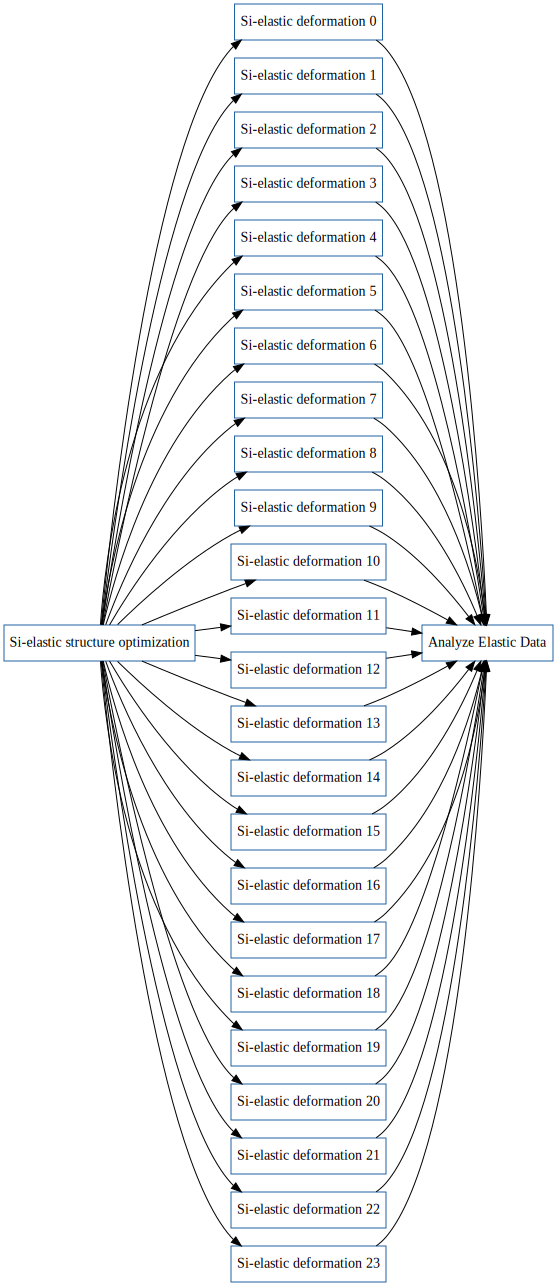

In [37]:
from mp_workshop.atomate import wf_to_graph
wf_to_graph(wf)

From our exploration of the workflow, we can see that the workflow has a "root" firework, which is the structure optimization firework, and a single "leaf" firework, which is the analysis task.  In between, we have several fireworks which have "elastic deformation" in their titles, each of which represents a calculation which will transform the output of the optimization firework by applying a unique strain.

In the analysis step, the stresses from those deformations and the strains are aggregated and used to fit an elastic tensor.  Let's examine the different types of fireworks using the graph tool.

Si-elastic structure optimization


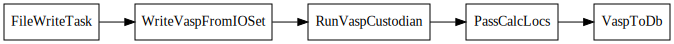

In [38]:
print(wf.fws[0].name)
wf_to_graph(wf.fws[0])

Si-elastic deformation 0


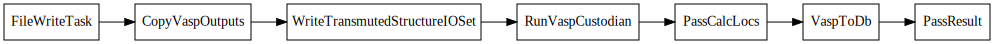

In [39]:
print(wf.fws[1].name)
wf_to_graph(wf.fws[1])

Analyze Elastic Data


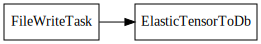

In [40]:
print(wf.fws[-1].name)
wf_to_graph(wf.fws[-1])

Note that the standard preset workflow for the elastic tensor uses many calculations in excess of what is required to determine the elastic tensor, which yields a higher-quality tensor in which some of the numerical noise is washed out over the duplicity of calculations.  Note that you can also generate a "minimal" elastic workflow which uses neither the more expensive DFT parameters nor the extended calculations.  Tensors generated using this workflow are typically not as accurate, but often work for simple semiconductors with a lot of symmetry.  Let's try it with bulk silicon.

In [58]:
wf = wf_elastic_constant_minimal(structure)

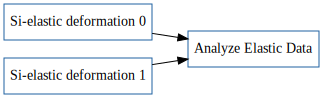

In [59]:
wf_to_graph(wf)

Note that for silicon, the two deformation tasks are a single normal deformation along the x axis (which are equivalent to those along the y- and z-axis), and a single shear deformation (equivalent to the two others normally included).  Since this is considerably simpler, we'll run this as our example.

To run the workflow, we import our launchpad and rocket launcher tools.  Since we can't use VASP in the workflow, we're also going to "fake" vasp by copying files rather than running the binary.

In [60]:
from fireworks import LaunchPad
from mp_workshop.atomate import use_fake_vasp_workshop

In [61]:
wf.name

'Si:elastic constants'

In [62]:
wf = use_fake_vasp_workshop(wf)
lpad.add_wf(wf)

2019-07-17 18:17:20,564 INFO Added a workflow. id_map: {-2432: 1, -2431: 2, -2430: 3}


{-2432: 1, -2431: 2, -2430: 3}

Now we can run the workflow either in the notebook using the pythonic fireworks rocket launcher or using `qlaunch` from the linux command line.

In [63]:
from fireworks.core.rocket_launcher import rapidfire

In [64]:
import os

In [65]:
if not os.path.exists('temp'):
    os.makedirs('temp')
    os.chdir("temp")
rapidfire(lpad)

2019-07-17 18:17:26,965 INFO Created new dir /home/jovyan/work/lessons/atomate/temp/temp/temp/launcher_2019-07-17-18-17-26-964974
2019-07-17 18:17:26,966 INFO Launching Rocket
2019-07-17 18:17:27,037 INFO RUNNING fw_id: 3 in directory: /home/jovyan/work/lessons/atomate/temp/temp/temp/launcher_2019-07-17-18-17-26-964974
2019-07-17 18:17:27,051 INFO Task started: FileWriteTask.
2019-07-17 18:17:27,052 INFO Task completed: FileWriteTask 
2019-07-17 18:17:27,066 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2019-07-17 18:17:27,082 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2019-07-17 18:17:27,087 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-17 18:17:27,108 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-17 18:17:27,131 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-17 18:17:27,133 INFO 

/opt/conda/lib/python3.7/site-packages/pymatgen/analysis/elasticity/elastic.py:911: UserWarning:

No eq state found, returning zero voigt stress



2019-07-17 18:17:29,098 INFO Task completed: {{atomate.vasp.firetasks.parse_outputs.ElasticTensorToDb}} 
2019-07-17 18:17:29,150 INFO Rocket finished


## Powerups

Atomate contains a number of tools for modifying workflows, known as "powerups" which are functions which will modify the workflows in commonly desired ways.  For example, if you want to modify the parameters of a VASP calculation, you can use the add_modify_incar powerup to change these for every firework in the workflow.

### add_modify_incar

In [66]:
from atomate.vasp.powerups import add_modify_incar

In [67]:
wf = get_wf(structure, "bandstructure.yaml")

In [84]:
wf_to_graph(wf.fws[0])

AttributeError: 'list' object has no attribute 'fws'

In [69]:
modified = add_modify_incar(wf, {"incar_update": {"ENCUT": 700}})

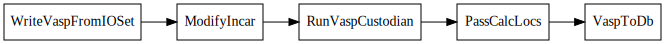

In [70]:
wf_to_graph(modified.fws[0])

Prior to the execution of the VASP calculation, a ModifyIncar firetask is inserted which will read the incar and modify the ENCUT parameter such that it matches our powerup specification.

### add_tags, add_structure_metadata

In [71]:
from atomate.vasp.powerups import add_tags

In [72]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization'}}


In [73]:
wf = add_tags(wf, ["photocathodes"])

In [74]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {'tags': ['photocathodes']}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization', 'tags': ['photocathodes']}}


## A few other "complex" workflows.

Atomate contains a few workflows that will do more complicating things like calculations on surfaces.  Let's say I want to calculate the determine the hydrogen adsorption energy on every low-index facet of Pt.

In [76]:
from atomate.vasp.workflows.base.adsorption import get_wfs_all_slabs
from pymatgen import MPRester, Molecule

In [77]:
pt = mpr.get_structure_by_material_id("Pt", conventional_unit_cell=True)
adsorbate = Molecule("H", [[0, 0, 0]])

In [86]:
wf = get_wfs_all_slabs(pt, adsorbates = [adsorbate])

/opt/conda/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_wyckoff. Missing values are set to None.

/opt/conda/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_equivalent. Missing values are set to None.



'WF 0 ============================='

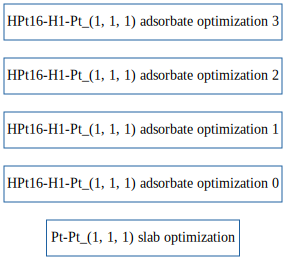

'WF 1 ============================='

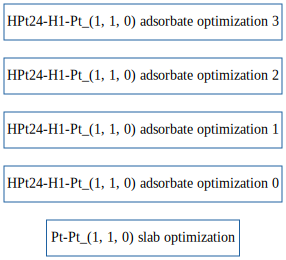

'WF 2 ============================='

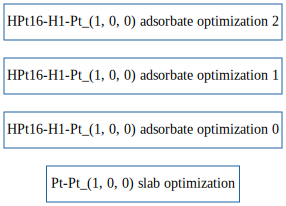

In [102]:
from IPython.display import display
display("WF 0 =============================")
display(wf_to_graph(wf[0]))
display("WF 1 =============================")
display(wf_to_graph(wf[1]))
display("WF 2 =============================")
display(wf_to_graph(wf[2]))

This is how you can do the requisite calculation to find the band-gap from an HSE calculation after the PBE bandstructure.

In [103]:
from atomate.vasp.workflows.presets.core import wf_bandstructure_plus_hse

In [104]:
wf = wf_bandstructure_plus_hse(structure)

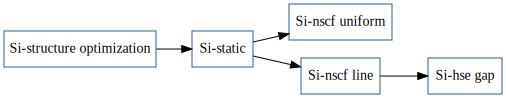

In [105]:
wf_to_graph(wf)

There's also support for workflows in FEFF and QChem.

In [106]:
from atomate.feff.workflows.core import get_wf_xas

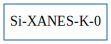

In [107]:
wf = get_wf_xas("Si", structure)
wf_to_graph(wf)

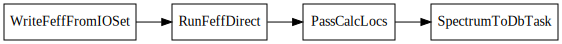

In [108]:
wf_to_graph(wf.fws[0])

In [109]:
#from atomate.qchem.workflows.base.double_FF_opt import get_wf_double_FF_opt
#from pymatgen import Molecule
#molecule = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
#wf = get_wf_double_FF_opt(molecule, 0.5)
#wf_to_graph(wf)
#wf_to_graph(wf.fws[0])

## Analyzing workflow results

Our final example for atomate will take a set of tasks from our database and construct a phase diagram.

To do this, we will first submit a series of structure optimizations using the `get_wf_from_spec_dict` utility which allows us to reuse the same calculation settings.

This is essentially like the `bandstructure.yaml` file we used for the band structure calculations earlier.
```
# A typical band structure
# Author: Anubhav Jain (ajain@lbl.gov)
fireworks:
- fw: atomate.vasp.fireworks.core.OptimizeFW
- fw: atomate.vasp.fireworks.core.StaticFW
  params:
    parents: 0
- fw: atomate.vasp.fireworks.core.NonSCFFW
  params:
    parents: 1
    mode: uniform
- fw: atomate.vasp.fireworks.core.NonSCFFW
  params:
    parents: 1
    mode: line
```


In [7]:
import json
from monty.serialization import loadfn
from atomate.utils.utils import get_wf_from_spec_dict

def get_custom_wf(struct, cal_yaml, add_tags={}):
    """
    Create a a customized atomate workflow from a yaml file
    """
    d = loadfn(cal_yaml)
    wf = get_wf_from_spec_dict(struct, d)
    return wf

Assuming we want to override a basic VASP flag

In [15]:
%%file opti.yaml  
fireworks:
# Relaxation for
- fw: atomate.vasp.fireworks.core.OptimizeFW
  override_default_vasp_params:
    user_incar_settings:
        ISPIN: 2


Overwriting opti.yaml


We can run this workflow on for materials in teh Al-Cr system

In [13]:
# get the structures in the Al-Cr system
# create workflows using those structures
# remember to modify the workflows using use_fake_vasp_workshop 

structures = mpr.get_structures("Al-Cr")
structures += mpr.get_structures("Al")
structures += mpr.get_structures("Cr")
for structure in structures:
    wf = get_custom_wf(structure, 'opti.yaml')
    wf = use_fake_vasp_workshop(wf)
    lpad.add_wf(wf)


2019-07-24 23:17:34,488 INFO Performing db tune-up
2019-07-24 23:17:34,521 INFO LaunchPad was RESET.
2019-07-24 23:17:35,263 INFO Added a workflow. id_map: {-1197: 1}
2019-07-24 23:17:35,277 INFO Added a workflow. id_map: {-1198: 2}
2019-07-24 23:17:35,300 INFO Added a workflow. id_map: {-1199: 3}
2019-07-24 23:17:35,313 INFO Added a workflow. id_map: {-1200: 4}
2019-07-24 23:17:35,320 INFO Added a workflow. id_map: {-1201: 5}
2019-07-24 23:17:35,329 INFO Added a workflow. id_map: {-1202: 6}
2019-07-24 23:17:35,336 INFO Added a workflow. id_map: {-1203: 7}
2019-07-24 23:17:35,345 INFO Added a workflow. id_map: {-1204: 8}
2019-07-24 23:17:35,353 INFO Added a workflow. id_map: {-1205: 9}
2019-07-24 23:17:35,361 INFO Added a workflow. id_map: {-1206: 10}
2019-07-24 23:17:35,371 INFO Added a workflow. id_map: {-1207: 11}
2019-07-24 23:17:35,378 INFO Added a workflow. id_map: {-1208: 12}


In [14]:
from fireworks.core.rocket_launcher import rapidfire
from mp_workshop.atomate import use_fake_vasp_workshop
import os
if not os.path.exists('temp'):
    os.makedirs('temp')
os.chdir("temp")
rapidfire(lpad)    
os.chdir("..")


2019-07-24 23:18:02,550 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-02-549968
2019-07-24 23:18:02,551 INFO Launching Rocket
2019-07-24 23:18:02,570 INFO RUNNING fw_id: 1 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-02-549968
2019-07-24 23:18:02,578 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:02,592 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:02,596 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:18:02,625 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-24 23:18:02,644 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-24 23:18:02,650 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-24 23:18:02,653 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-24 23:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:04,091 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-24 23:18:04,092 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-24 23:18:04,096 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-24 23:18:04,098 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}} 
2019-07-24 23:18:04,109 INFO Task started: {{atomate.vasp.firetasks.parse_outputs.VaspToDb}}.
2019-07-24 23:18:04,111 INFO atomate.vasp.firetasks.parse_outputs PARSING DIRECTORY: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-03-915397
2019-07-24 23:18:04,111 INFO atomate.vasp.drones Getting task doc for base dir :/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-03-915397
2019-07-24 23:18:05,607 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-03-915397
2019-07-24 23:18:05,608 WARNING atomate.vasp.drones Transformations file d

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/run_calc.py", line 276, in run_task
    self._verify_inputs()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/run_calc.py", line 287, in _verify_inputs
    ref_incar = Incar.from_file(os

2019-07-24 23:18:05,846 INFO RUNNING fw_id: 4 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-05-814710
2019-07-24 23:18:05,863 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:05,882 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:05,886 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:18:05,916 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-24 23:18:05,941 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-24 23:18:05,944 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-24 23:18:05,949 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-24 23:18:05,952 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}} 
2019-07-24 23:18:05,957 INFO Task started: {{atomate.vasp.firetasks.parse

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:07,025 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-06-500068
2019-07-24 23:18:07,026 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:07,036 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-06-500068
2019-07-24 23:18:07,051 INFO Rocket finished
2019-07-24 23:18:07,055 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-055855
2019-07-24 23:18:07,056 INFO Launching Rocket
2019-07-24 23:18:07,075 INFO RUNNING fw_id: 6 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-055855
2019-07-24 23:18:07,088 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:07,095 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:07,100 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:07,465 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-055855
2019-07-24 23:18:07,468 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:07,480 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-055855
2019-07-24 23:18:07,500 INFO Rocket finished
2019-07-24 23:18:07,508 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-508138
2019-07-24 23:18:07,509 INFO Launching Rocket
2019-07-24 23:18:07,530 INFO RUNNING fw_id: 7 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-508138
2019-07-24 23:18:07,537 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:07,545 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:07,552 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:08,031 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-508138
2019-07-24 23:18:08,032 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:08,044 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-07-508138
2019-07-24 23:18:08,057 INFO Rocket finished
2019-07-24 23:18:08,063 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-063339
2019-07-24 23:18:08,064 INFO Launching Rocket
2019-07-24 23:18:08,082 INFO RUNNING fw_id: 8 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-063339
2019-07-24 23:18:08,091 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:08,097 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:08,102 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:08,429 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-063339
2019-07-24 23:18:08,430 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:08,443 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-063339
2019-07-24 23:18:08,464 INFO Rocket finished
2019-07-24 23:18:08,472 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-472358
2019-07-24 23:18:08,473 INFO Launching Rocket
2019-07-24 23:18:08,495 INFO RUNNING fw_id: 9 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-472358
2019-07-24 23:18:08,502 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:08,510 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:08,514 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:09,115 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-472358
2019-07-24 23:18:09,116 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:09,132 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-08-472358
2019-07-24 23:18:09,144 INFO Rocket finished
2019-07-24 23:18:09,149 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-149061
2019-07-24 23:18:09,150 INFO Launching Rocket
2019-07-24 23:18:09,163 INFO RUNNING fw_id: 10 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-149061
2019-07-24 23:18:09,173 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:09,178 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:09,182 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:09,845 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-149061
2019-07-24 23:18:09,846 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:09,861 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-149061
2019-07-24 23:18:09,876 INFO Rocket finished
2019-07-24 23:18:09,880 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-880263
2019-07-24 23:18:09,881 INFO Launching Rocket
2019-07-24 23:18:09,903 INFO RUNNING fw_id: 11 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-880263
2019-07-24 23:18:09,911 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:09,919 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:09,923 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:10,477 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-880263
2019-07-24 23:18:10,478 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:10,491 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-09-880263
2019-07-24 23:18:10,511 INFO Rocket finished
2019-07-24 23:18:10,518 INFO Created new dir /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-10-518440
2019-07-24 23:18:10,519 INFO Launching Rocket
2019-07-24 23:18:10,539 INFO RUNNING fw_id: 12 in directory: /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-10-518440
2019-07-24 23:18:10,543 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-24 23:18:10,551 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-24 23:18:10,558 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-24 23

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


2019-07-24 23:18:11,122 INFO atomate.vasp.drones Post-processing dir:/home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-10-518440
2019-07-24 23:18:11,123 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-24 23:18:11,136 INFO atomate.vasp.drones Post-processed /home/lik/lessons/atomate/temp/launcher_2019-07-24-23-18-10-518440
2019-07-24 23:18:11,150 INFO Rocket finished


Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 106, in run_task
    db_file = env_chk(self.get('db_file'), fw_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/utils/utils.py", line 59, in env_chk
    return fw_spec['_fw_env'][val[2:-2]]
KeyError: 'db_file'


## The calculations have finished

When atomates runs a Quantum Chemistry calculation, the output is stored in a collection defined by the db.json file.

IMPORTANT: The location of this file will be different depending on how you setup your system, and this db.json file must be access on the computing cluster where your simulation are running.


In [34]:
!cat /home/lik/mp_workshop/fireworks_config/db.json

{
    "aliases": {}, 
    "collection": "tasks",
    "database": "mp_workshop",
    "host": "localhost", 
    "port": 27017
}


The data from our fake vasp calculations are used to populate the `tasks` collection on `localhost:mp_workshop`. 

To access these results we can use `pymongo` or our wrapper for `pymongo` --- (`maggma`) 

In [41]:
# We can look at these results by querying database
from maggma.stores import MongoStore
tasks = MongoStore(database="mp_workshop", collection_name="tasks")
tasks.connect()
tasks.query_one()

{'_id': ObjectId('5d38e011f0909b0e13c1e8ff'),
 'dir_name': 'fbb1a4b9189d:/home/lik/lessons/atomate/temp/launcher_2019-07-24-22-47-44-482690',
 'analysis': {'delta_volume': -0.004862971687160211,
  'delta_volume_as_percent': -0.012854040771655955,
  'max_force': 0.001528790232471414,
  'warnings': [],
  'errors': []},
 'calcs_reversed': [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35',
   'has_vasp_completed': True,
   'nsites': 3,
   'is_hubbard': False,
   'hubbards': {},
   'elements': ['Al', 'Cr'],
   'nelements': 2,
   'run_type': 'None or LDA',
   'input': {'incar': {'ISTART': 1,
     'PREC': 'accurate',
     'ALGO': 'Fast',
     'ISPIN': 2,
     'ICHARG': 1,
     'NELM': 100,
     'IBRION': 2,
     'EDIFF': 0.00015,
     'NSW': 99,
     'ISIF': 3,
     'ENCUT': 520.0,
     'MAGMOM': [0.6, 5.0, 5.0],
     'LREAL': 'Auto',
     'ISMEAR': -5,
     'SIGMA': 0.05,
     'LWAVE': False,
     'LORBIT': 11,
     'KPOINT_BSE': [-1, 0, 0, 0]},
    'kpoints': {'comment': 'Kpoints from vasprun

In [42]:
tasks = MongoStore(database="mp_workshop", collection_name="tasks")

In [17]:
tasks.connect()

In [18]:
doc = tasks.query_one()

In [19]:
doc.keys()

dict_keys(['_id', 'dir_name', 'analysis', 'calcs_reversed', 'chemsys', 'completed_at', 'composition_reduced', 'composition_unit_cell', 'custodian', 'elements', 'formula_anonymous', 'formula_pretty', 'formula_reduced_abc', 'input', 'last_updated', 'nelements', 'nsites', 'orig_inputs', 'output', 'run_stats', 'schema', 'state', 'task_id', 'task_label', 'transformations'])

In [20]:
doc['chemsys']

'Al-Cr'

In [21]:
doc = tasks.query_one(criteria={"chemsys": "Al"}, properties=['output'])

In [22]:
docs = tasks.query(criteria={"chemsys": "Al-Cr", 
                             "task_label": "structure optimization"},
                   properties=['output', 'formula_pretty'])
docs

In [23]:
docs = list(docs)

In [24]:
[d['formula_pretty'] for d in docs]

['AlCr2', 'Al8Cr5', 'Al3Cr']

In [25]:
fe_cr_tasks = []
for chemsys in ['Al', 'Cr', 'Al-Cr']:
    task_list = tasks.query(criteria={"chemsys": chemsys,
                                      "task_label": "structure optimization"},
                            properties=["output", "composition_unit_cell"])
    fe_cr_tasks.extend(list(task_list))

In [26]:
len(fe_cr_tasks)

11

In [27]:
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen import Composition

In [28]:
entries = []
for task in fe_cr_tasks:
    energy = task['output']['energy']
    composition = Composition.from_dict(task['composition_unit_cell'])
    entry = ComputedEntry(composition, energy)
    entries.append(entry)

In [29]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

In [30]:
pd = PhaseDiagram(entries)

In [31]:
plotter = PDPlotter(pd)

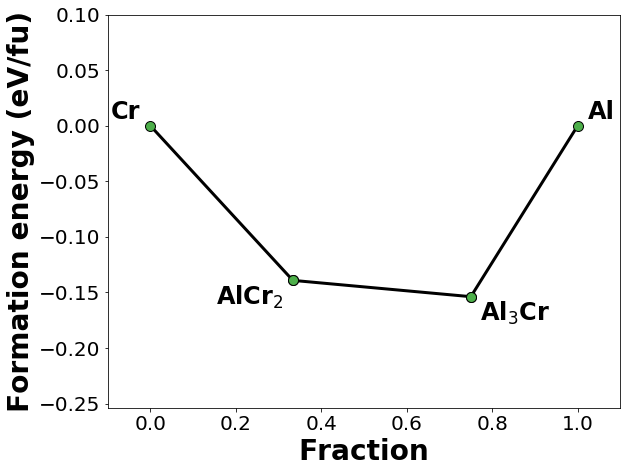

In [32]:
plotter.show()

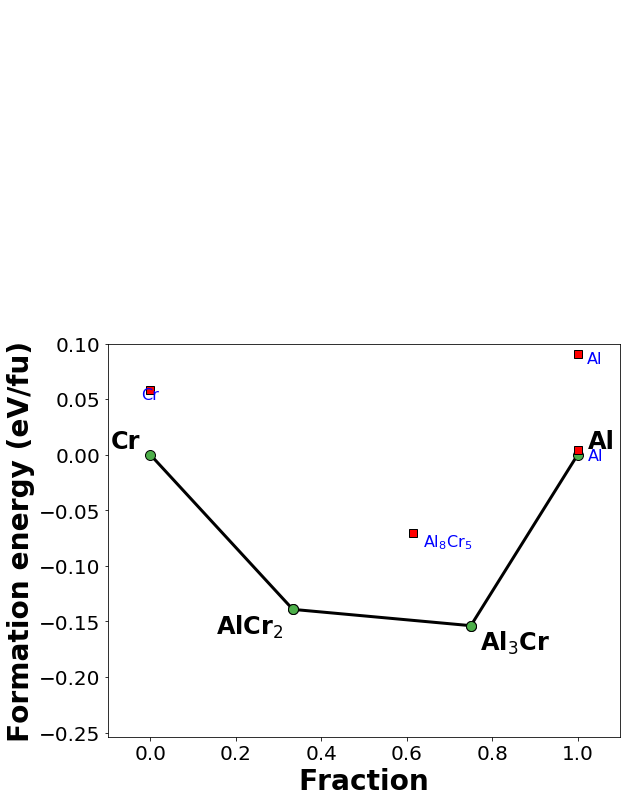

In [33]:
plotter.show_unstable = True
plotter.show()